# Configuration

In [1]:
# Model Configuration
CONTEXT_LENGTH = 512  # Fixed context length for chunks
EMBEDDING_DIM = 256  # Dimension of the token embeddings
NUM_HEADS = 8  # Number of attention heads
NUM_LAYERS = 3  # Number of transformer layers
QK_HEAD_DIM = 16  # Dimension of the query and key heads
V_HEAD_DIM = 32  # Dimension of the value head
MLP_DIM = 1024  # Dimension of the hidden layers in the transformer
DROPOUT_RATE = 0.1  # Dropout rate for regularization

# Data Configuration
VOCAB_SIZE = 512  # Size of the vocabulary
PADDING = True # Whether to pad sequences
PACKING = True # Whether to pack sequences for training

# Training Configuration
SEED = 42  # Random seed for reproducibility
BATCH_SIZE = 128  # Batch size for training
EPOCHS = 10 # Number of epochs to train
SAMPLE_LIMIT = 200000  # Set to None to process the entire dataset
LR = 0.001  # Learning rate for the optimizer
WEIGHT_DECAY = 0.01  # Weight decay for the optimizer
BETA1 = 0.9  # Beta1 for the Adam optimizer
BETA2 = 0.999  # Beta2 for the Adam optimizer

# File Paths and Labels
TOKENIZER_FILE = "./data/tinystories-tokenizer"
CHUNK_FILE = "./data/chunked_stories"
LOG_DIR = None
# LOG_DIR = './runs/2025-08-26_17-09-10'
DICT_LABEL = 'seq'

In [2]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

from datasets import load_dataset
from tokenizers import Tokenizer

from tensorboardX import SummaryWriter

from models.torch import SmallLanguageModel, loss_fn, print_story
from data.utils import train_tokenizer, chunk_story, create_dict_parameters, encode_story, pack_stories, pretty_json

In [3]:
params = create_dict_parameters(locals())
LOG_DIR = f'runs/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}' if LOG_DIR is None else LOG_DIR
writer = SummaryWriter(log_dir=LOG_DIR)
if len(list(Path(LOG_DIR).glob('events.out.tfevents.*'))) == 1:
    print(f"Logging parameters")
    writer.add_text('Parameters', pretty_json(params))

Logging parameters


# Tokenizer

In [4]:
tokenizer_path = f'{TOKENIZER_FILE}_{VOCAB_SIZE}_{SAMPLE_LIMIT}.json'
if os.path.exists(tokenizer_path):
    tokenizer = Tokenizer.from_file(tokenizer_path)
    print(f"Tokenizer file {tokenizer_path} already exists. Skipping training.")
else:
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    if SAMPLE_LIMIT:
        dataset = dataset.select(range(min(SAMPLE_LIMIT, len(dataset))))
    tokenizer = train_tokenizer(dataset, vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]", "\n"])
    tokenizer.save(tokenizer_path)
    print(f"Tokenizer saved to {tokenizer_path}")

sos_token_id = tokenizer.token_to_id('[SOS]')
eos_token_id = tokenizer.token_to_id('[EOS]')
pad_token_id = tokenizer.token_to_id('[PAD]')

tokenizer = Tokenizer.from_file(tokenizer_path)
encoded = tokenizer.encode("Once upon a time, there was a little fox.\nIt lived in a forest and loved to explore.")

print("\n--- Testing the Tokenizer ---")
print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)
print("Decoded:", tokenizer.decode(encoded.ids, skip_special_tokens=True))

Tokenizer file ./data/tinystories-tokenizer_512_200000.json already exists. Skipping training.

--- Testing the Tokenizer ---
Tokens: [' Once', ' upon', ' a', ' time,', ' there', ' was', ' a', ' little', ' f', 'o', 'x', '.', '\n', ' It', ' li', 'ved', ' in', ' a', ' f', 'ore', 'st', ' and', ' loved', ' to', ' ex', 'pl', 'ore', '.']
IDs: [302, 321, 126, 350, 272, 149, 126, 269, 140, 82, 91, 20, 4, 276, 245, 297, 185, 126, 140, 299, 236, 132, 382, 133, 346, 493, 299, 20]
Decoded: Once upon a time, there was a little fox. It lived in a forest and loved to explore.


# Chunking

Chunk file ./data/chunked_stories_512_512_200000_padding_packing.npz already exists. Skipping chunking.


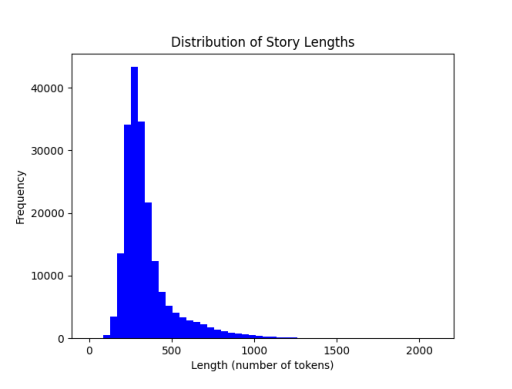

In [5]:
if PADDING and PACKING:
    chunk_file_path = f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding_packing.npz'
elif PADDING:
    chunk_file_path = f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding.npz'
elif PACKING:
    chunk_file_path = f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_packing.npz'
else:
    chunk_file_path = f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}.npz'
figure_path = f'./figures/histogram_{VOCAB_SIZE}_{SAMPLE_LIMIT}.png'
if os.path.exists(chunk_file_path):
    print(f"Chunk file {chunk_file_path} already exists. Skipping chunking.")

    # display the existing histogram
    plt.imshow(plt.imread(figure_path))
    plt.axis('off')
else:
    # Load the dataset
    if not ('dataset' in locals()):
        dataset = load_dataset("roneneldan/TinyStories", split="train")
        if SAMPLE_LIMIT:
            dataset = dataset.select(range(min(SAMPLE_LIMIT, len(dataset))))

    # Load the tokenizer
    tokenizer = Tokenizer.from_file(tokenizer_path)

    # Process all stories and collect chunks
    all_chunks = []
    unfinished_chunk = []
    num_non_special_tokens = []
    for story in tqdm(dataset["text"], desc="Chunking stories"):
        if PACKING:
            story_chunks, non_special_token_count = encode_story(story, tokenizer, '[SOS]', '[EOS]')
            all_chunks.append(story_chunks)
        else:
            story_chunks, unfinished_chunk, non_special_token_count = chunk_story(story, tokenizer, '[SOS]', '[EOS]', CONTEXT_LENGTH,
                                                            unfinished_chunk=unfinished_chunk, padding=PADDING, pad_token='[PAD]')
            all_chunks.extend(story_chunks)
        num_non_special_tokens.append(non_special_token_count)

    # Convert list to numpy array for efficient storage
    if PACKING:
        chunks_array = np.array(pack_stories(all_chunks, CONTEXT_LENGTH, tokenizer.token_to_id('[PAD]')), dtype=np.int32)
    else:
        chunks_array = np.array(all_chunks, dtype=np.int32)
    unique_tokens, counts = np.unique(chunks_array, return_counts=True)

    # Print statistics
    print(f"Total tokens: {CONTEXT_LENGTH * chunks_array.shape[0]:,}")
    print(f"Total non-special tokens: {np.sum(counts[3:]):,}")
    print(f"Number of special tokens: {np.sum(counts[:3]):,}")
    print(f"Array shape: {chunks_array.shape}")

    # Save the chunks to a compressed file
    print(f"Saving chunks to {chunk_file_path}...")
    np.savez_compressed(chunk_file_path, chunks=chunks_array)
    print(f"Saved successfully! File size: {os.path.getsize(chunk_file_path) / (1024 * 1024):.2f} MB")
    if PADDING and PACKING:
        text_info_path = f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding_packing.txt'
    elif PADDING:
        text_info_path = f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding.txt'
    elif PACKING:
        text_info_path = f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_packing.txt'
    else:
        text_info_path = f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}.txt'

    plt.hist(num_non_special_tokens, bins=50, color='blue')
    plt.title("Distribution of Story Lengths")
    plt.xlabel("Length (number of tokens)")
    plt.ylabel("Frequency")
    plt.savefig(figure_path)

    with open(text_info_path, 'w') as f:
        f.write(f"Sample limit: {SAMPLE_LIMIT:,}\n")
        f.write(f"Vocabulary Size: {VOCAB_SIZE:,}\n")
        f.write(f"Context length: {CONTEXT_LENGTH:,}\n")
        f.write(f"Number of chunks: {chunks_array.shape[0]:,}\n")
        f.write(f"Number of tokens: {CONTEXT_LENGTH * chunks_array.shape[0]:,}\n")
        f.write(f"Number of non-special tokens: {np.sum(counts[3:]):,}\n")
        f.write(f"Number of special tokens: {np.sum(counts[:3]):,}\n")
        f.write(f"Padding used: {PADDING}\n")
        f.write(f"Packing used: {PACKING}\n")

# Data Pipeline

In [6]:
torch.manual_seed(SEED)
data = np.load(chunk_file_path)['chunks']

# Create dataset
class StoryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = StoryDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
shuffle=True)
num_batches = len(dataloader)
print(f"Number of batches per epoch: {num_batches}")

Number of batches per epoch: 966


In [7]:
for x in dataloader:
    x = x.numpy()
    print(x.shape)
    print(type(x))
    text = tokenizer.decode(x[0], skip_special_tokens=False).split(' ')
    for i in range(0, len(text), 30):
        print(' '.join(text[i:i+30]))
    text = tokenizer.decode(x[BATCH_SIZE-1], skip_special_tokens=False).split(' ')
    for i in range(0, len(text), 30):
        print(' '.join(text[i:i+30]))
    break  # Just to test the first batch

(128, 512)
<class 'numpy.ndarray'>
[SOS] Once upon a time, there was a boy named Timmy. Timmy was a very clean boy who loved to play outside. One day, Timmy's mom asked him to clean
up his toys before he could go outside to play. Timmy didn't want to clean up and said, "I don't want to clean up, I want to go play outside
now!"

 Timmy's mom replied, "Timmy, it's important to clean up after ourselves. If we don't, our toys will get lost or broken. Plus, it's not fair to leave a mess
for someone else to clean up."

 Timmy thought about what his mom said and realized she was right. He cleaned up his toys and went outside to play. Later that
day, Timmy's friend came over and saw how clean Timmy's room was. His friend said, "Wow, Timmy! Your room is so clean! I wish my room was as clean as
yours."

 Timmy smiled and said, "Thanks! My mom taught me that it's important to clean up after ourselves and not leave a mess for someone else to clean up."[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

# Model

In [8]:
model = SmallLanguageModel(vocab_dim=VOCAB_SIZE, embed_dim=EMBEDDING_DIM, n_head=NUM_HEADS, num_layers=NUM_LAYERS, qk_head_dim=QK_HEAD_DIM, v_head_dim=V_HEAD_DIM, mlp_dim=MLP_DIM, max_len=CONTEXT_LENGTH, dropout_rate=DROPOUT_RATE)
model.to(device)
print(f"Number of parameters in the model: {sum(param.numel() for param in model.parameters()):,}")
optimizer = optim.AdamW(model.parameters(), lr=LR, betas=[BETA1, BETA2], weight_decay=WEIGHT_DECAY)

Number of parameters in the model: 2,432,256


# Training

In [9]:
if os.path.exists(f'{LOG_DIR}/checkpoint.pt'):
    checkpoint = torch.load(f'{LOG_DIR}/checkpoint.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    torch.set_rng_state(checkpoint['rng_state'])
    start_epoch_from = checkpoint['start_epoch_from']
    print(f"Resuming training from epoch {start_epoch_from}.")
else:
    start_epoch_from = 0

In [10]:
generate_story_freq = np.ceil(num_batches / 2) + 1
for epoch in range(start_epoch_from, EPOCHS):
    losses = []
    for i, seq in enumerate(dataloader):
        tensor_seq = seq.to(device)
        input_seq = tensor_seq[:, :-1]  # Exclude the last token for input
        target_seq = tensor_seq[:, 1:]  # Exclude the first token for target
        optimizer.zero_grad()
        loss = loss_fn(model, input_seq, target_seq, pad_token_id=pad_token_id if PADDING else None)
        loss.backward()
        optimizer.step()
        print(f"Batch {i}, Loss: {loss.item():.4f}")
        writer.add_scalar('Loss/train', loss.item(), epoch * num_batches + i)
        if (i+1) % generate_story_freq == 0:
            tokens = model.generate('[SOS]', tokenizer, max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=1.0)
            print_story(tokens, tokenizer)
        losses.append(loss.item())
    #     break
    # break
    avg_loss = np.mean(losses)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    writer.add_scalar('Loss/epoch_train', avg_loss.item(), epoch)
    tokens = model.generate('[SOS]', tokenizer, max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=1.0)
    print_story(tokens, tokenizer)
    checkpoint = {
        'start_epoch_from': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
        'loss': avg_loss,
    }
    torch.save(checkpoint, f'{LOG_DIR}/checkpoint.pt')
writer.add_hparams(params, {'hparam/last_loss': avg_loss.item()})

Batch 0, Loss: 6.3825
Batch 1, Loss: 5.9966
Batch 2, Loss: 5.7431
Batch 3, Loss: 5.5903
Batch 4, Loss: 5.4793
Batch 5, Loss: 5.3770
Batch 6, Loss: 5.2801
Batch 7, Loss: 5.1703
Batch 8, Loss: 5.0967
Batch 9, Loss: 4.9891
Batch 10, Loss: 4.9429
Batch 11, Loss: 4.8451
Batch 12, Loss: 4.7593
Batch 13, Loss: 4.6891
Batch 14, Loss: 4.6242
Batch 15, Loss: 4.5500
Batch 16, Loss: 4.5034
Batch 17, Loss: 4.4227
Batch 18, Loss: 4.3651
Batch 19, Loss: 4.2915
Batch 20, Loss: 4.2370
Batch 21, Loss: 4.1997
Batch 22, Loss: 4.1425
Batch 23, Loss: 4.0916
Batch 24, Loss: 4.0600
Batch 25, Loss: 4.0291
Batch 26, Loss: 3.9663
Batch 27, Loss: 3.9759
Batch 28, Loss: 3.9535
Batch 29, Loss: 3.8676
Batch 30, Loss: 3.8634
Batch 31, Loss: 3.8482
Batch 32, Loss: 3.7910
Batch 33, Loss: 3.7920
Batch 34, Loss: 3.7781
Batch 35, Loss: 3.7456
Batch 36, Loss: 3.7300
Batch 37, Loss: 3.6884
Batch 38, Loss: 3.6821
Batch 39, Loss: 3.6611
Batch 40, Loss: 3.6317
Batch 41, Loss: 3.6379
Batch 42, Loss: 3.6181
Batch 43, Loss: 3.610

In [25]:
tokens = model.generate('[SOS]', tokenizer, max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=0.2)
print_story(tokens, tokenizer)

Once upon a time, there was a little girl named Lily. She loved to play with her toys and run around the house. One day, 
she saw a big, red balloon in the sky. She wanted to play with it, but she didn't know how. Lily asked her mom, "Can 
I play with it?" Her mom said, "Sure, but be careful." Lily was happy to hear that. She ran to the balloon and started to 
play with it. As she played, she saw a big, red balloon. It was a big, red balloon! Lily was so happy to have her 
balloon. She ran to the balloon and started to play with it. She had so much fun playing with it all day. As she played 
with the balloon all day long, she noticed that it was time to go home. Lily was sad to leave the balloon behind her. She 
learned that it's important to listen to her mom and not be rude to her friends. 

--------------------
